# **Lab4 : Image Segmentation (Histogram of Oriented Gradients & K-Mean Clustering)**

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import measure


import glob

from sklearn.cluster import KMeans

from scipy import spatial

from tqdm import tqdm
import cv2
import os 
import random

## Load Image

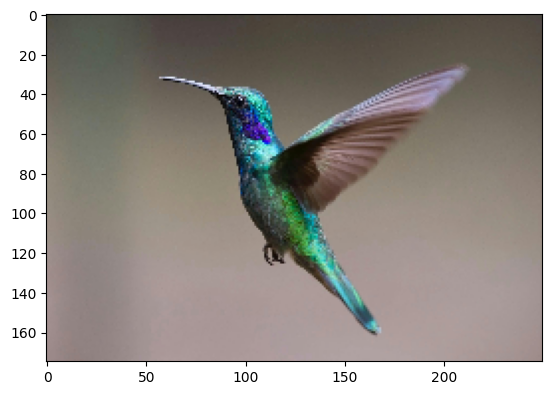

In [2]:
### START CODE HERE ###
image = cv2.resize(cv2.cvtColor(cv2.imread(r'C:\Users\Nickv\Documents\ImageProcessing\Week4\asset\Bird.jpg'), cv2.COLOR_BGR2RGB), (250, 175))
plt.imshow(image)
plt.show()
### END CODE HERE ###

## Histogram of Oriented Gradients

Blur the image then apply to the [`hog()`](<https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog:~:text=skimage.feature.hog(,%23>)
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/1.png?raw=true)
</details>

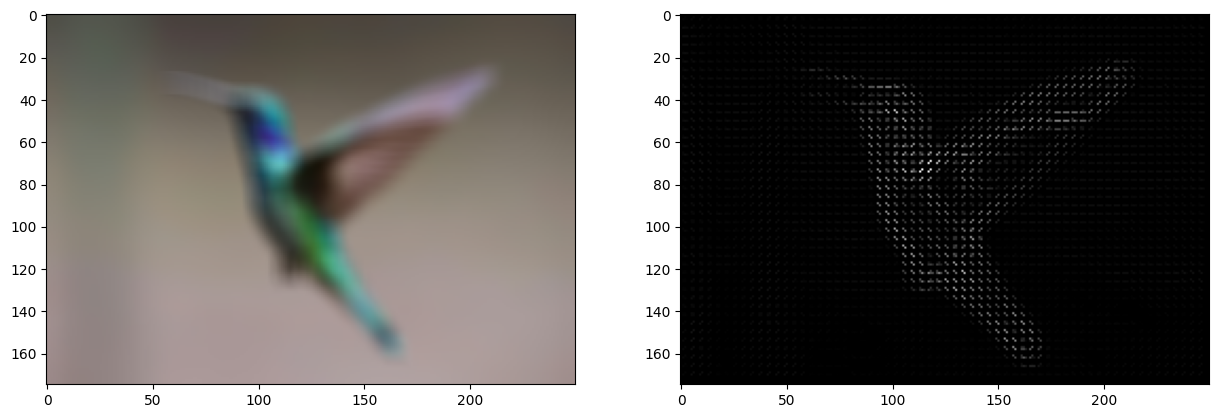

In [3]:
### START CODE HERE ###

blurry_image = cv2.GaussianBlur(image, (11, 11), 10)
fd, hog_image = hog(blurry_image, orientations=9, pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))

axs[0].imshow(blurry_image)
axs[1].imshow(hog_image, cmap='gray')

plt.show()

### END CODE HERE ###

Complete the `HOGSubimageExtractor()`.

That extracts Histogram of Oriented Gradients features from sub-images of a larger image. It divides the image into overlapping tiles, computes HOG features for each tile, and stores both the feature vectors and visualizations. The class also provides a method to plot the HOG visualizations.

**Attributes:**
- `image`: The input image.
- `tile_size`: The size of each sub-image to extract.
- `stride`: The pixel stride between consecutive sub-images.
- `hGrid`: An array of indices representing the starting positions for rows of sub-images.
- `wGrid`: An array of indices representing the starting positions for columns of sub-images.
- `hog_features`: A list to store the HOG feature vectors for each sub-image.
- `hog_images`: A list to store the visualized HOG images for each sub-image (optional).

**Methods:**
- `extract_hog_features()`: Compute HOG features for each sub-image.
- `plot_hog_images()`: Plots the HOG visualization images.
- `get_num_grid()`: Return the number of rows and columns in the grid of sub-images.


In [4]:
### START CODE HERE ###
class HOGSubimageExtractor:
    def __init__(self, image, tile_size, stride):
        self.image = image
        self.tile_size = tile_size
        self.stride = stride
        self.h, self.w, _ = image.shape
        self.hGrid = []
        self.wGrid = []
        self.hog_features = []
        self.hog_images = []
        self.extract_hog_features()

    def extract_hog_features(self):
        self.hGrid = []
        self.wGrid = []
        self.hog_features = []
        self.hog_images = []

        for y in range(0, self.h - self.tile_size + 1, self.stride):
            for x in range(0, self.w - self.tile_size + 1, self.stride):
                sub_img = self.image[y:y+self.tile_size, x:x+self.tile_size]
                hog_feature, hog_image = hog(
                    sub_img, 
                    pixels_per_cell=(self.tile_size//8, self.tile_size//8),
                    cells_per_block=(2, 2), 
                    visualize=True, 
                    channel_axis=-1
                )
                self.hog_features.append(hog_feature)
                self.hog_images.append(hog_image)
                self.hGrid.append(y)
                self.wGrid.append(x)
                
        return self.hog_features

    def plot_hog_images(self):
        num_tiles = len(self.hog_images)
        num_cols = (self.w - self.tile_size) // self.stride + 1
        num_rows = (self.h - self.tile_size) // self.stride + 1
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
        if num_rows == 1:
            axes = [axes]

        for idx, ax in enumerate(axes.flat):
            if idx < num_tiles:
                ax.imshow(self.hog_images[idx], cmap='gray')
                ax.axis('off')
            else:
                ax.remove()
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.show()

    def get_num_grid(self):
        return len(self.hGrid), len(self.wGrid)
### END CODE HERE ###


Let's use `HOGSubimageExtractor()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output from hog_extractor.plot_hog_images()</b>
</font>
</summary>

- The output should resemble this, but not be identical

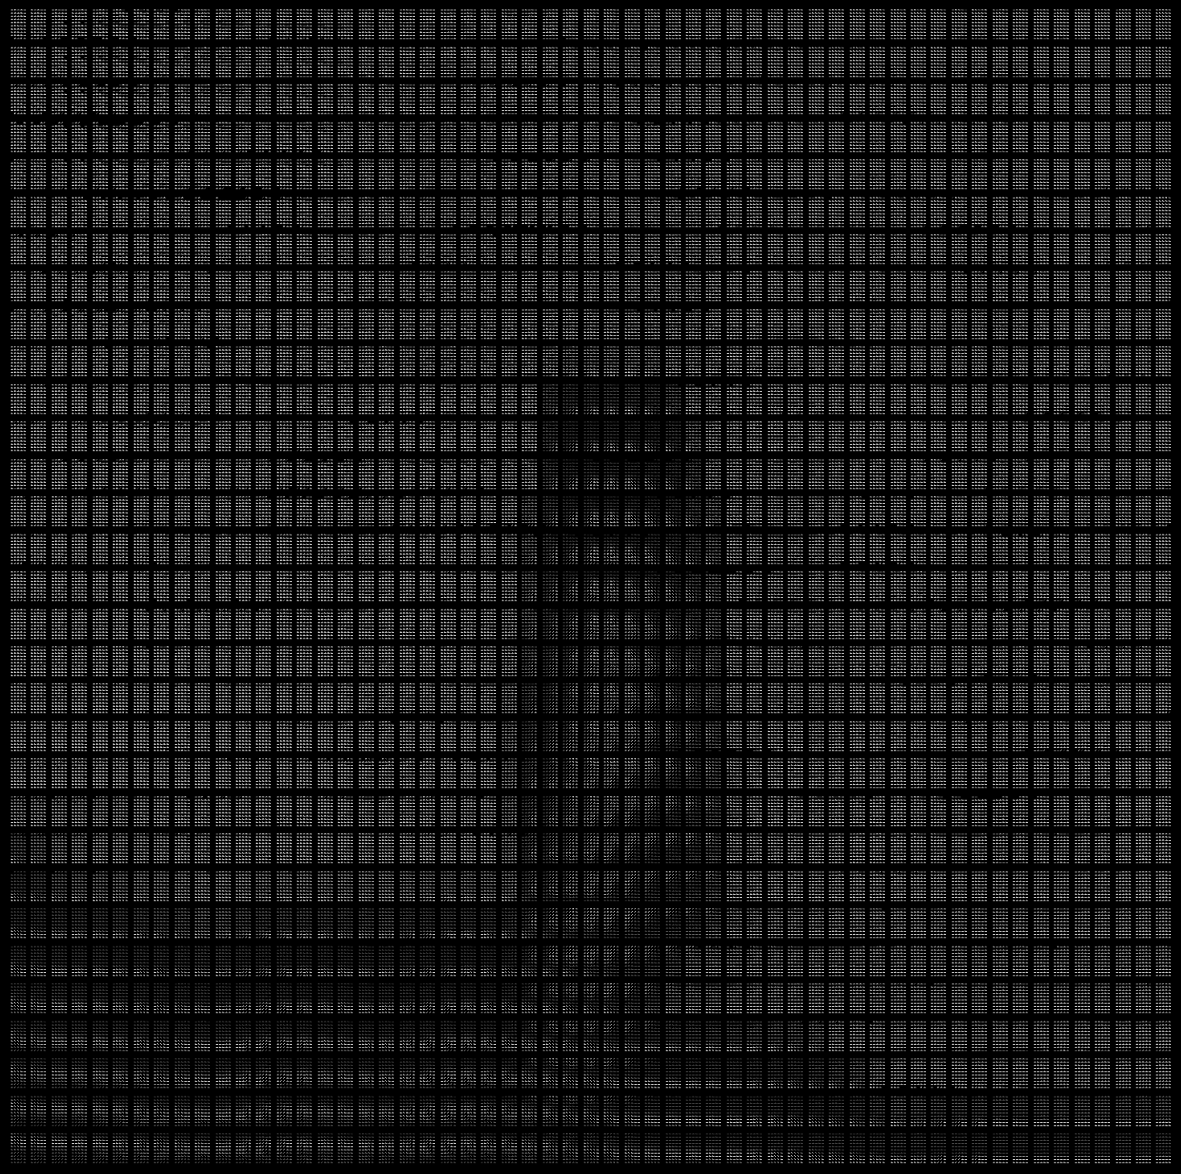
</details>

Number of grids: (600, 600)


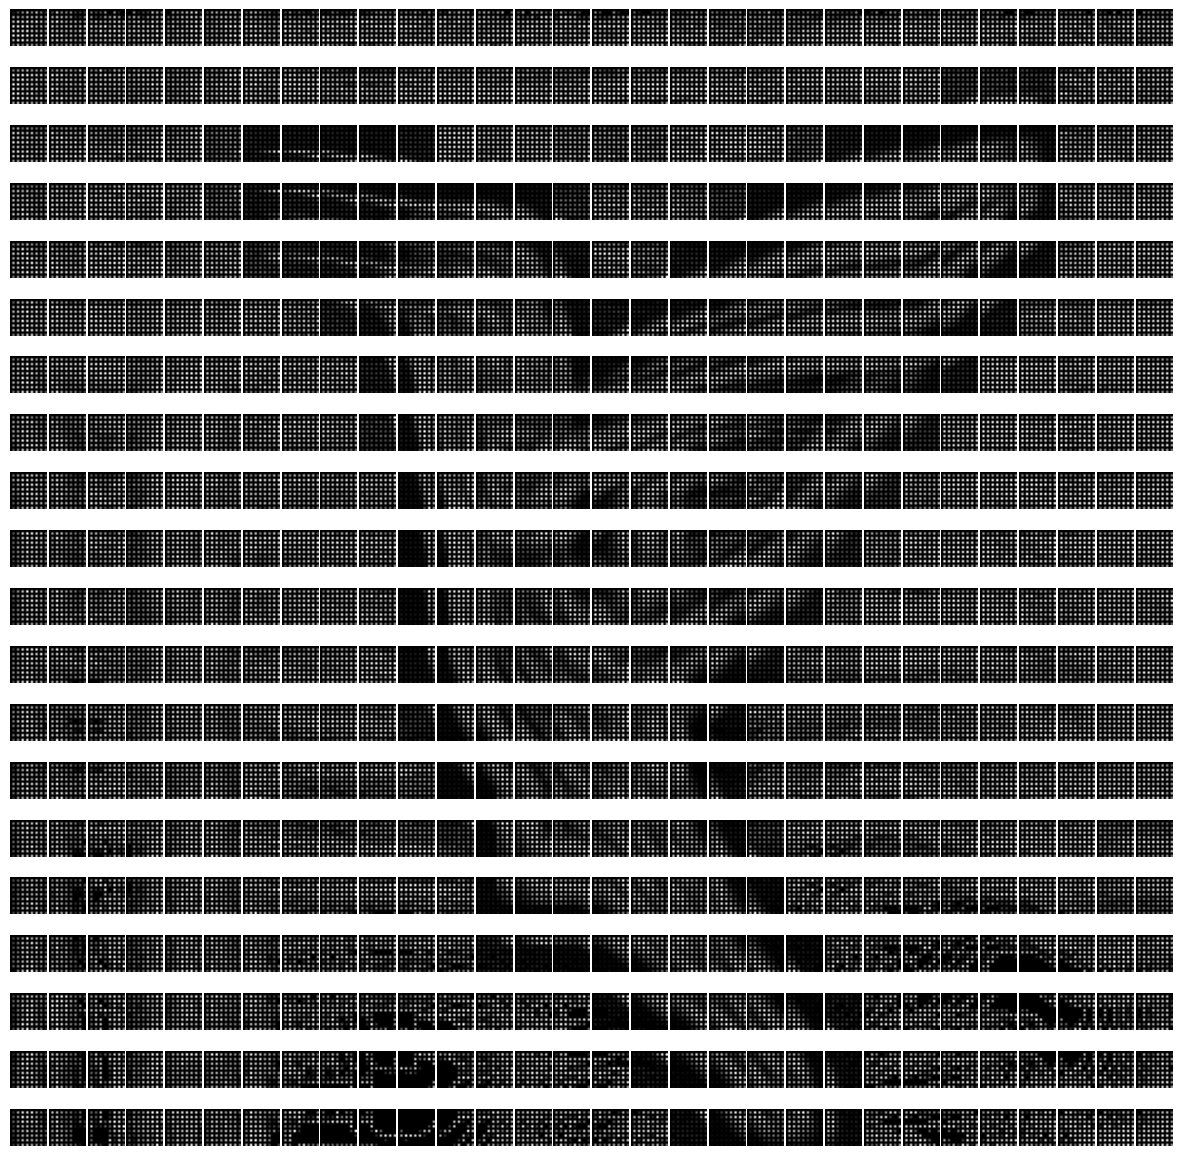

In [5]:
### START CODE HERE ###
tile_size = 16
stride = 8
hog_extractor = HOGSubimageExtractor(blurry_image, tile_size, stride)
num_grid = hog_extractor.get_num_grid()
print(f'Number of grids: {num_grid}')
hog_extractor.plot_hog_images()
### END CODE HERE ###

## K-Mean Clustering
Complete the `KMeansCluster()`.
Perform K-means clustering on Histogram of Oriented Gradients (HOG) features extracted from an image.
**Attriburtes:**
- `hog_extractor`: An object responsible for extractin HOG features from an image.
- `n_clusters`: The number of clusters to use in K-means.
- `cluster_array`: A 2D array representing the cluster assignments for each grid cell.
- `all_labels`: A 2D array representing the connected components (objects) identified after clustering.
- `bounding_boxes`: A list of tuples containing (object_id, start_coordinates, end_coordinates) for each detected object.

**Method:**
- `perform_clustering()`: Performs K-means clustering on the HOG features extracted by the hog_extractor object.<br>
It then reshapes the cluster assignmentss into a grid and identifies connected components using the `measure.label()` function.
- `plot_cluster_and_labels()`: Visualize the cluster assignments and connected components as images using Matplotlib.
- `get_bounding_boxes()`: Extracts bounding boxes for each detected object.

In [6]:
### START CODE HERE ###
class KMeansCluster:
    def __init__(self, hog_extractor, n_clusters, random_state):
        self.hog_extractor = hog_extractor
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.cluster_array = None
        self.all_labels = None
        self.bounding_boxes = None
        self.perform_clustering()

    def perform_clustering(self):
        hog_features = self.hog_extractor.extract_hog_features()
        
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        kmeans.fit(hog_features)
        cluster_labels = kmeans.labels_

        num_rows = (self.hog_extractor.h - self.hog_extractor.tile_size) // self.hog_extractor.stride + 1
        num_cols = (self.hog_extractor.w - self.hog_extractor.tile_size) // self.hog_extractor.stride + 1

        self.cluster_array = cluster_labels.reshape((num_rows, num_cols))
        
        self.all_labels = measure.label(self.cluster_array)

    def plot_cluster_and_labels(self):
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.title("Cluster Assignments")
        plt.imshow(self.cluster_array, cmap='viridis')
        
        plt.subplot(1, 2, 2)
        plt.title("Connected Components")
        plt.imshow(self.all_labels, cmap='nipy_spectral')
        
        plt.show()

    def get_bounding_boxes(self, scale_x, scale_y, min_area=100):
        self.bounding_boxes = []

        regions = measure.regionprops(self.all_labels)

        for region in regions:
            if region.area >= min_area:
                start_x = int(region.bbox[1] * scale_x)
                start_y = int(region.bbox[0] * scale_y)
                end_x = int(region.bbox[3] * scale_x)
                end_y = int(region.bbox[2] * scale_y)

                self.bounding_boxes.append((region.label, (start_x, start_y), (end_x, end_y)))

        return self.bounding_boxes

    
### END CODE HERE ###

Complete the function below. Using [`cv2.rectangle()`](<https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html#:~:text=511%2C511)%2C(255%2C0%2C0)%2C5)-,Drawing%20Rectangle,-To%20draw%20a>)

In [7]:
### START CODE HERE ###
def draw_bbox(image, bboxes):
    for object_id, start_coords, end_coords in bboxes:
        start_x, start_y = start_coords
        end_x, end_y = end_coords

        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), color=(0, 255, 0), thickness=2)
       
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.show()

### END CODE HERE ###

Let's use `KMeansCluster()` and `draw_bbox()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-3.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/3.png?raw=true)

![image-4.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/4.png?raw=true)
</details>

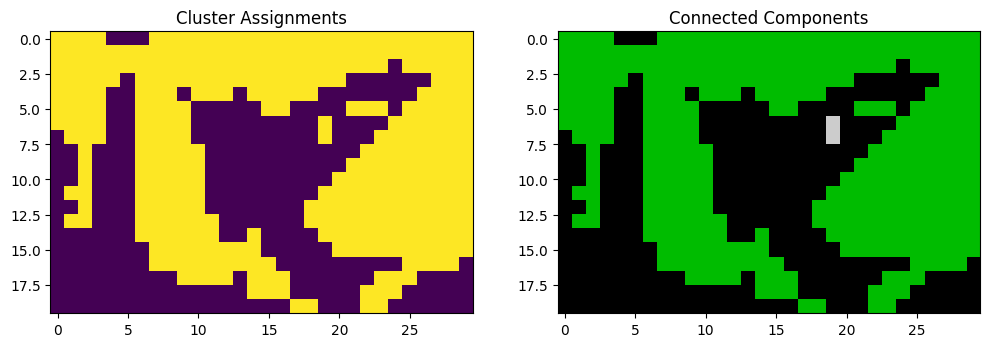

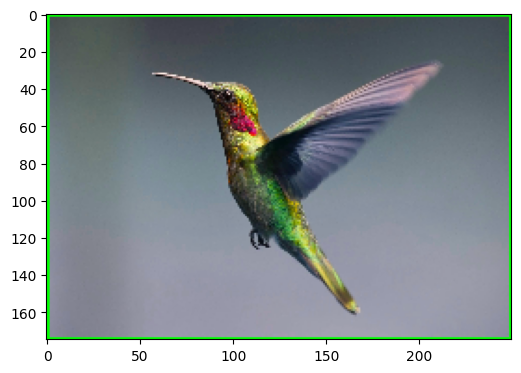

In [8]:
kmeans_cluster = KMeansCluster(hog_extractor, 2, 32)
kmeans_cluster.plot_cluster_and_labels()
cluster_rows, cluster_cols = kmeans_cluster.cluster_array.shape
scale_x = image.shape[1] / cluster_cols
scale_y = image.shape[0] / cluster_rows
bboxes = kmeans_cluster.get_bounding_boxes(scale_x, scale_y)
image = cv2.resize(cv2.cvtColor(cv2.imread(r'C:\Users\Nickv\Documents\ImageProcessing\Week4\asset\Bird.jpg'), cv2.COLOR_BGR2RGB), (250, 175))
draw_bbox(image, bboxes)

---

## Experiment
Do the experiment to identify 3 best parameters that produce the perfectly fitting bounding box of the object of interest in the image.

Number of grids: (600, 600)


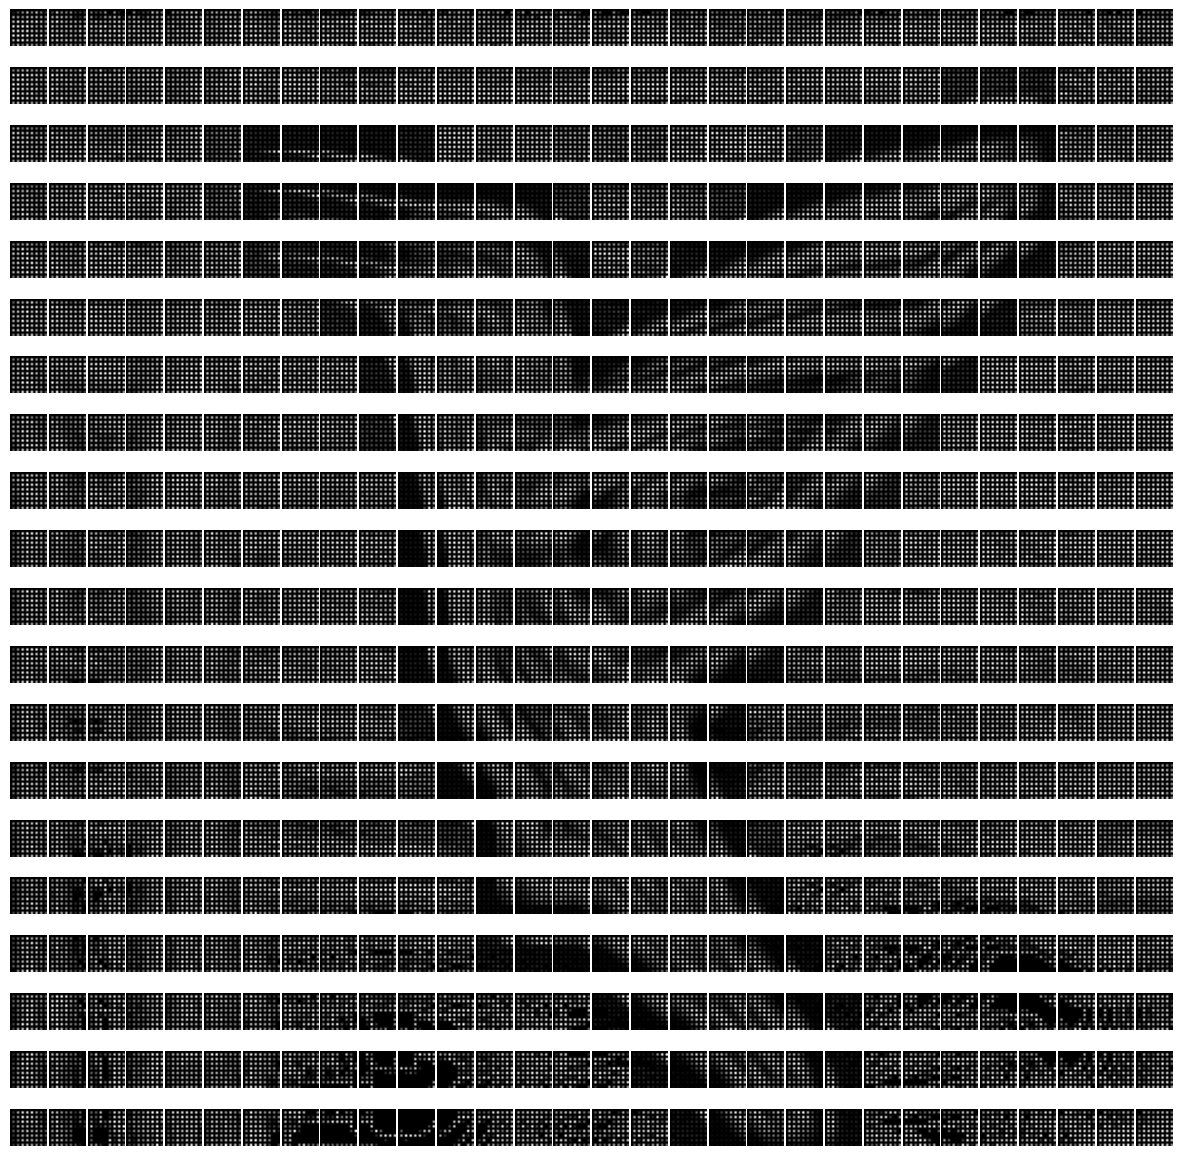

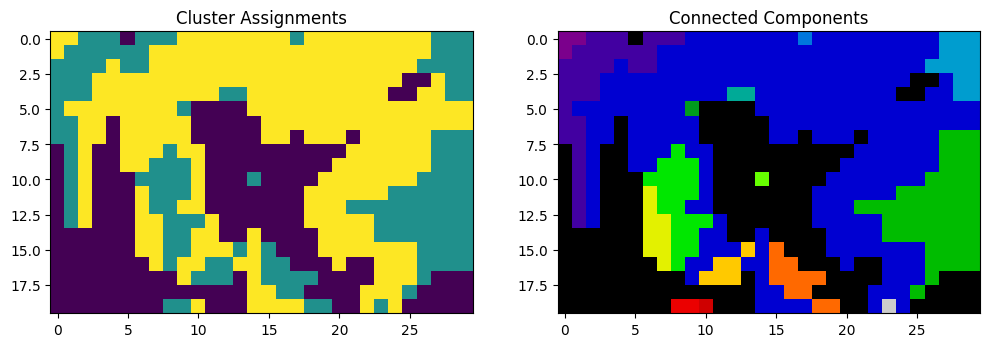

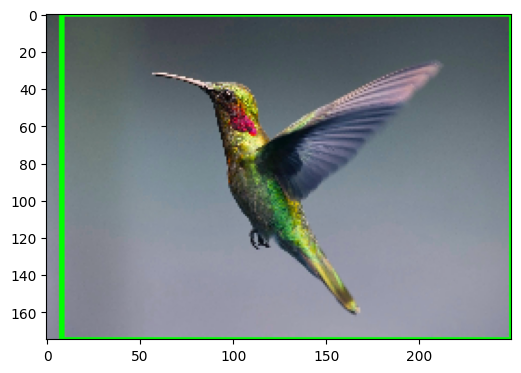

In [9]:
### START CODE HERE ###

tile_size = 16
stride = 8
hog_extractor = HOGSubimageExtractor(blurry_image, tile_size, stride)
num_grid = hog_extractor.get_num_grid()
print(f'Number of grids: {num_grid}')
hog_extractor.plot_hog_images()

kmeans_cluster = KMeansCluster(hog_extractor, 3, 32)
kmeans_cluster.plot_cluster_and_labels()
cluster_rows, cluster_cols = kmeans_cluster.cluster_array.shape
scale_x = image.shape[1] / cluster_cols
scale_y = image.shape[0] / cluster_rows
bboxes = kmeans_cluster.get_bounding_boxes(scale_x, scale_y)
image = cv2.resize(cv2.cvtColor(cv2.imread(r'C:\Users\Nickv\Documents\ImageProcessing\Week4\asset\Bird.jpg'), cv2.COLOR_BGR2RGB), (250, 175))
draw_bbox(image, bboxes)

### END CODE HERE ###

Number of grids: (336, 336)


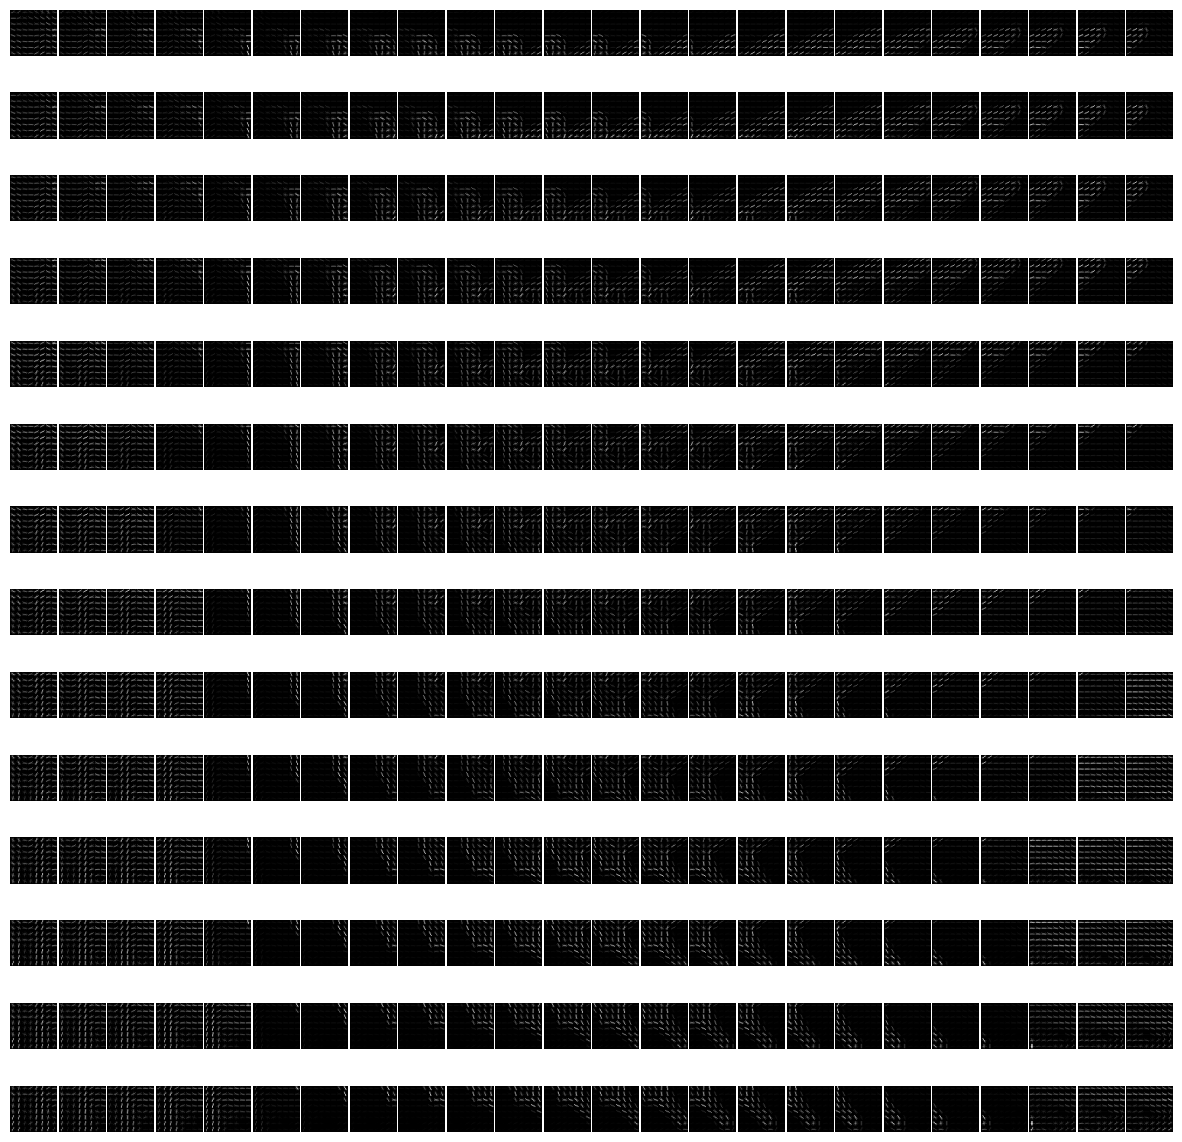

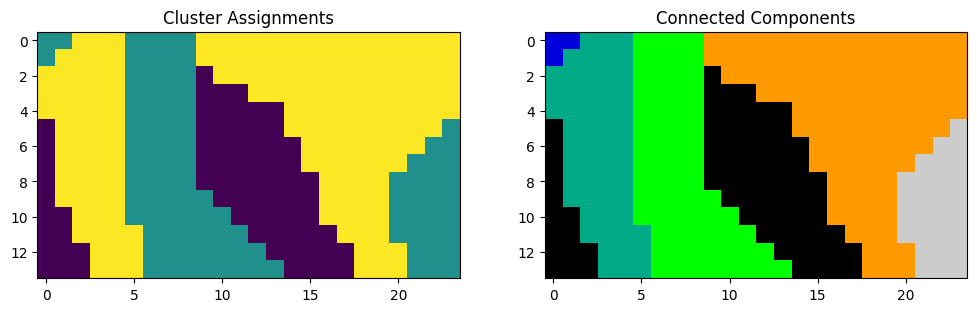

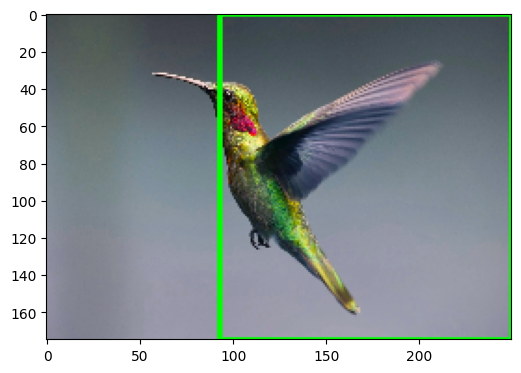

In [10]:
### START CODE HERE ###

tile_size = 64
stride = 8

hog_extractor = HOGSubimageExtractor(blurry_image, tile_size, stride)
num_grid = hog_extractor.get_num_grid()
print(f'Number of grids: {num_grid}')
hog_extractor.plot_hog_images()

kmeans_cluster = KMeansCluster(hog_extractor, 3, 32)
kmeans_cluster.plot_cluster_and_labels()
cluster_rows, cluster_cols = kmeans_cluster.cluster_array.shape
scale_x = image.shape[1] / cluster_cols
scale_y = image.shape[0] / cluster_rows
bboxes = kmeans_cluster.get_bounding_boxes(scale_x, scale_y)
image = cv2.resize(cv2.cvtColor(cv2.imread(r'C:\Users\Nickv\Documents\ImageProcessing\Week4\asset\Bird.jpg'), cv2.COLOR_BGR2RGB), (250, 175))
draw_bbox(image, bboxes)


### END CODE HERE ###

Number of grids: (504, 504)


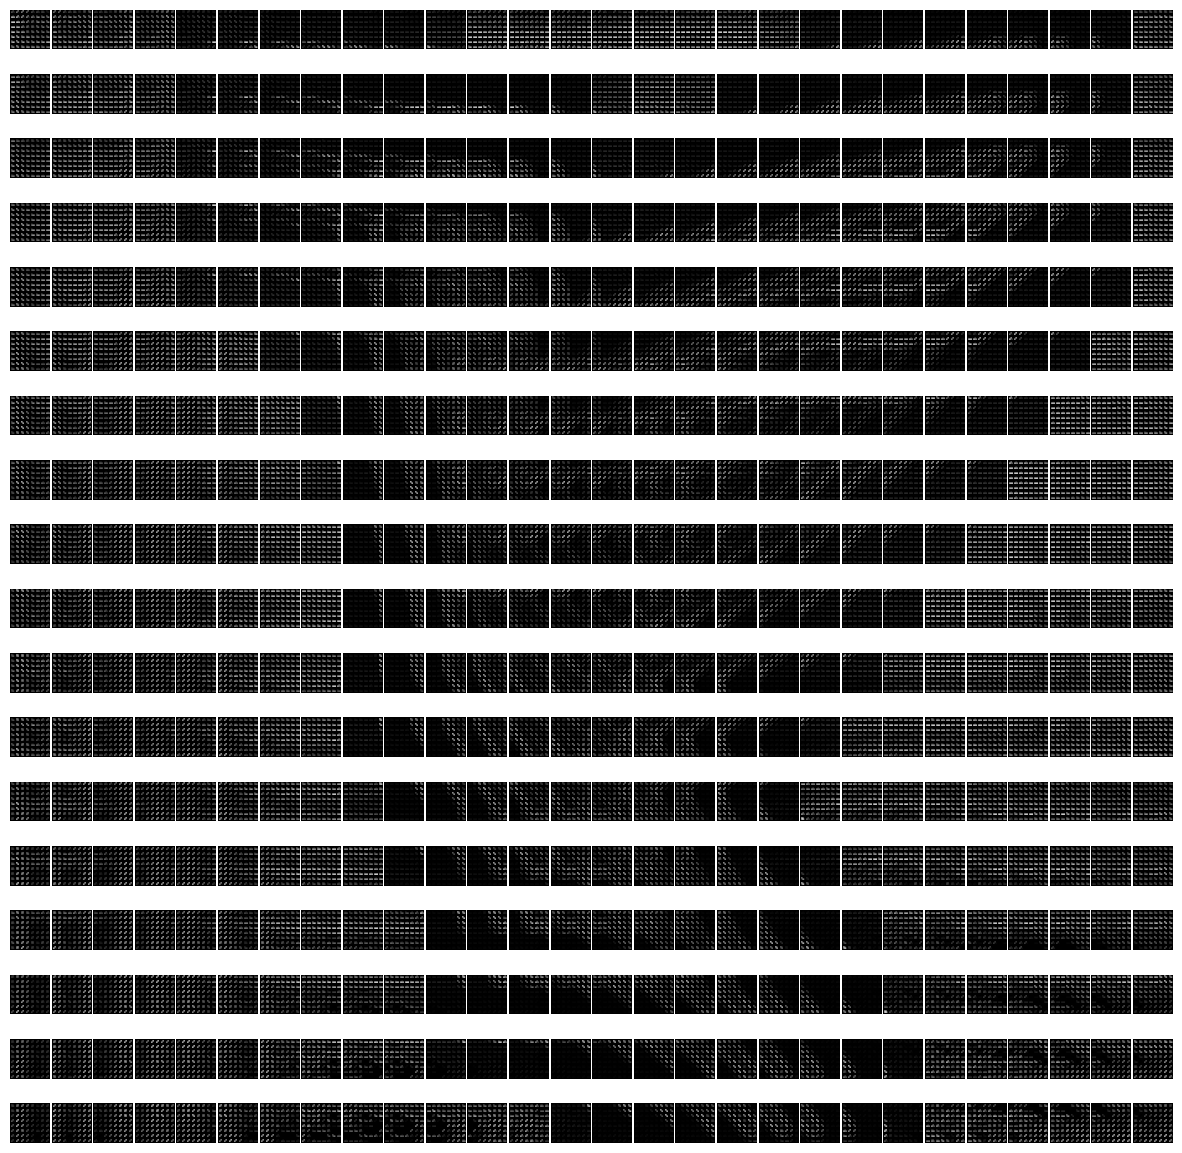

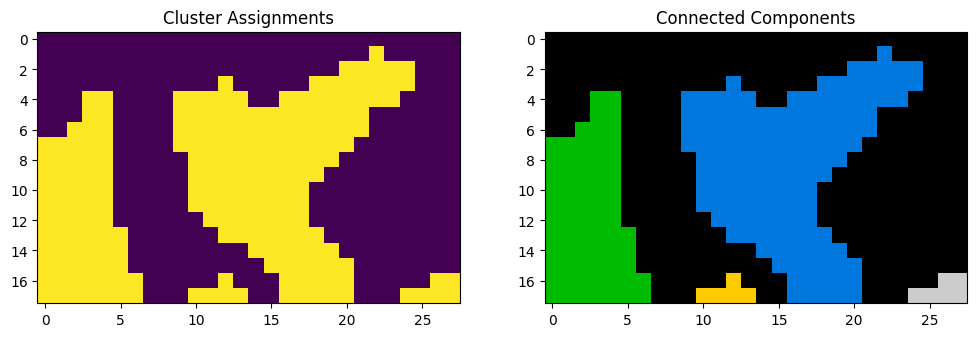

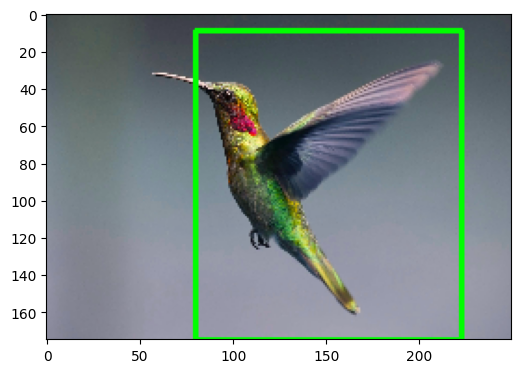

In [11]:
### START CODE HERE ###

tile_size = 32
stride = 8

hog_extractor = HOGSubimageExtractor(blurry_image, tile_size, stride)
num_grid = hog_extractor.get_num_grid()
print(f'Number of grids: {num_grid}')
hog_extractor.plot_hog_images()

kmeans_cluster = KMeansCluster(hog_extractor, 2, 32)
kmeans_cluster.plot_cluster_and_labels()
cluster_rows, cluster_cols = kmeans_cluster.cluster_array.shape
scale_x = image.shape[1] / cluster_cols
scale_y = image.shape[0] / cluster_rows
bboxes = kmeans_cluster.get_bounding_boxes(scale_x, scale_y)
image = cv2.resize(cv2.cvtColor(cv2.imread(r'C:\Users\Nickv\Documents\ImageProcessing\Week4\asset\Bird.jpg'), cv2.COLOR_BGR2RGB), (250, 175))
draw_bbox(image, bboxes)

### END CODE HERE ###

---

## **Question** 
1. How do the parameters of Gaussian blur, such as kernel size and standard deviation, affect the image processing in the context of k-means clustering?

2. How do the configurations of cells per block and pixels per cell influence the effectiveness of object detection in an image?

3. What differences can be observed in the clustering results when using smaller sub-images (tiles) compared to larger ones?

4. What is the impact on object detection if the labeling step is skipped before applying k-means clustering?

5. How does the choice of the number of clusters (K) in k-means clustering affect the image clustering result (right) of an input image (left)? 
Discuss the trade-offs between too few and too many clusters in accurately representing the test patterns.<br>

![q5.jpg](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/q5.jpg?raw=true)


1. ในการทำ Gaussian Blur จะต้องใช้ Kernel ที่มี Dimension เป็นเลขคี่เช่น (3, 3) หรือ (5, 5) เนื่องจากจะต้องทำการ convolution ซึ่งก็คือการคูณค่าของพิกเซลที่ตำแหน่งนั้นๆกับค่าของ Kernel ตามตำแหน่งที่ตรงกันแล้วนำผลลัพธ์มารวมกันเพื่อให้ได้ค่าพิกเซลใหม่ ดังนั้นเมื่อเพิ่มขนาด kernel จะทำให้ภาพผลลัพท์ blur มากขึ้นเพราะจะมีการคำนวณจากข้อมูลรอบข้างในพื้นที่ที่กว้างขึ้น ส่วนการเพิ่ม SD ใน Gaussian function ก็จะทำให้ภาพ blur มากขึ้นเช่นกันเพราะ weight จะมีการกระจายตัวมากขึ้น

2. cells per block คือจำนวนของ cell ใน 1 block ซึ่งถ้ายิ่งมีจำนวน cell มากก็จะมีความละเอียดที่น้อยลง sensitive ต่อเเสงเเละคอนทราสน้อยลงทำให้ เเบ่งกลุ่มไดด้ง่ายขึ้น ซึ่งถ้าจำนวน cell น้อยก็จะมีผลตรงกันข้าม
pixels per cell คือขนาดของ cell ยิ่ง cell มีขนาด เล็กลง ฟีเจอร์ที่ได้ก็จะมีความละเอียดสูง แต่จะต้องแลกกับความต้องการในการคำนวณที่มากขึ้น
ตรงข้ามกับขนาด cell ที่ใหญ่

3. เมื่อขนาด tile ใหญ่ขึ้นก็จะมีจำนวน grid ลดลง Detail ลดลง ตรวจจับ connected components ได้ลดลงกลับกันกับเมื่อขนาด tile เล็กลง

4. ขั้นตอน Label ช่วยให้เเยก connected components ซึ่งจะเชื่อม pixels ที่มีค่าเหมือนกันเเละอยู่ติดกัน ที่ได้จาก cluster ถ้าขาดขั้นตอนนี้ก็อาจจะเเยกวัตถุได้เเม่นยำน้อยลงเพราะอาจมี pixel ค่าเดียวกันที่ไม่ติดกันเเต่ถูกรวมว่าเป็นวัตถุเดียวกัน

5. ถ้าค่า K น้อยเกินไปอาจทำให้ข้อมูลที่หลากหลายถูกจัดกลุ่มรวมกันมากเกินไป ส่งผลให้ผลลัพธ์ที่ได้ไม่สามารถแสดงรายละเอียดของกลุ่มข้อมูลที่แตกต่างกันได้อย่างถูกต้อง 
ถ้าค่า K มากเกินไปอาจทำให้เกิดการแบ่งกลุ่มที่ซับซ้อนเกินไป ซึ่งอาจทำให้เกิดกลุ่มย่อยที่ไม่มีความหมายจริงในข้อมูล ส่งผลให้ผลลัพธ์ที่ได้มีความซับซ้อนและอาจทำให้การตีความหมายของผลลัพธ์ยากขึ้น
การเลือกจำนวนคลัสเตอร์ที่เหมาะสมจะช่วยให้สามารถจับลักษณะของข้อมูลได้ดี ในขณะที่การเลือกจำนวนที่น้อยหรือมากเกินไปอาจทำให้ผลลัพธ์ไม่เป็นไปตามที่คาดหวังได้ ดังนั้นการเลือกจำนวนคลัสเตอร์ที่เหมาะสมจึงสำคัญเพื่อให้การแยกกลุ่มข้อมูลมีความแม่นยำและสามารถตีความได้อย่างถูกต้อง